<a href="https://colab.research.google.com/github/SaurabhVora/Real-World-Project-Using-LSTM-and-Random-Forest/blob/main/Bus_Station_Using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (1) Importing all libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#(2) Load The Dataset and Processing dataset

In [2]:
data = pd.read_csv('civil_court1.csv')


In [3]:
data.shape , data.info() , data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51623 entries, 0 to 51622
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Date_Time        51623 non-null  object
 1   Sid              51623 non-null  int64 
 2   Did              51623 non-null  int64 
 3   Station_Pair     51623 non-null  object
 4   Is_Holiday       51623 non-null  int64 
 5   Holiday_Type     51623 non-null  int64 
 6   OneHourSlot      51623 non-null  int64 
 7   Month            51623 non-null  int64 
 8   Year             51623 non-null  int64 
 9   Weekday          51623 non-null  int64 
 10  Passenger_Count  51623 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 4.3+ MB


((51623, 11),
 None,
            Sid      Did    Is_Holiday  Holiday_Type   OneHourSlot  \
 count  51623.0  51623.0  51623.000000  51623.000000  51623.000000   
 mean       5.0      8.0      0.070666      1.003739     12.500223   
 std        0.0      0.0      0.256269      4.209717      6.922136   
 min        5.0      8.0      0.000000      0.000000      1.000000   
 25%        5.0      8.0      0.000000      0.000000      7.000000   
 50%        5.0      8.0      0.000000      0.000000     13.000000   
 75%        5.0      8.0      0.000000      0.000000     18.500000   
 max        5.0      8.0      1.000000     27.000000     24.000000   
 
               Month          Year       Weekday  Passenger_Count  
 count  51623.000000  51623.000000  51623.000000     51623.000000  
 mean       6.555566   2020.855936      3.001375         7.119675  
 std        3.472553      1.742519      1.999685         9.443618  
 min        1.000000   2018.000000      0.000000         0.000000  
 25%   

In [4]:
data.head()

,Date_Time,Sid,Did,Station_Pair,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Passenger_Count
0,01-06-2018 01:00,5,8,Civil/Court-Thane Station West,0,0,2,6,2018,4,0
1,01-06-2018 02:00,5,8,Civil/Court-Thane Station West,0,0,3,6,2018,4,0
2,01-06-2018 03:00,5,8,Civil/Court-Thane Station West,0,0,4,6,2018,4,0
3,01-06-2018 04:00,5,8,Civil/Court-Thane Station West,0,0,5,6,2018,4,0
4,01-06-2018 05:00,5,8,Civil/Court-Thane Station West,0,0,6,6,2018,4,0


In [5]:
# Convert 'Date_Time' to datetime and set as index
data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%d-%m-%Y %H:%M')
data.set_index('Date_Time', inplace=True)

In [6]:
data.head()

,Sid,Did,Station_Pair,Is_Holiday,Holiday_Type,OneHourSlot,Month,Year,Weekday,Passenger_Count
Date_Time,,,,,,,,,,
2018-06-01 01:00:00,5,8,Civil/Court-Thane Station West,0,0,2,6,2018,4,0
2018-06-01 02:00:00,5,8,Civil/Court-Thane Station West,0,0,3,6,2018,4,0
2018-06-01 03:00:00,5,8,Civil/Court-Thane Station West,0,0,4,6,2018,4,0
2018-06-01 04:00:00,5,8,Civil/Court-Thane Station West,0,0,5,6,2018,4,0
2018-06-01 05:00:00,5,8,Civil/Court-Thane Station West,0,0,6,6,2018,4,0


In [7]:
# Selecting relevant columns for LSTM
features = data[['Is_Holiday', 'Holiday_Type', 'OneHourSlot', 'Month', 'Year', 'Weekday', 'Passenger_Count']]

# (3) Normalize the features

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [9]:
# Create sequences of data for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, -1]  # Passenger_Count is the target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
SEQ_LENGTH = 24  # Using past 24 hours to predict the next hour
X, y = create_sequences(scaled_features, SEQ_LENGTH)

In [11]:
# Split data into training and testing sets
split_ratio = 0.8
split_idx = int(len(X) * split_ratio)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# (4) Define the LSTM model

In [12]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [13]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, 7)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
1032/1032 [==============================] - 34s 26ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 2/20
1032/1032 [==============================] - 23s 22ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 3/20
1032/1032 [==============================] - 27s 27ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 4/20
1032/1032 [==============================] - 22s 22ms/step - loss: 0.0034 - val_loss: 0.0056
Epoch 5/20
1032/1032 [==============================] - 22s 22ms/step - loss: 0.0034 - val_loss: 0.0053
Epoch 6/20
1032/1032 [==============================] - 23s 22ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 7/20
1032/1032 [==============================] - 22s 21ms/step - loss: 0.0032 - val_loss: 0.0066
Epoch 8/20
1032/1032 [==============================] - 21s 20ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 9/20
1032/1032 [==============================] - 23s 22ms/step - loss: 0.0029 - val_loss: 0.0054
Epoch 10/20
1032/1032 [==============================] - 21s 21m

In [16]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

323/323 [==============================] - 3s 6ms/step - loss: 0.0053
Test Loss: 0.005318755283951759


# (5) Make predictions

In [17]:
y_pred = model.predict(X_test)

323/323 [==============================] - 3s 6ms/step


In [18]:
# Inverse transform the predictions and true values
y_test_scaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 6)), y_test.reshape(-1, 1)), axis=1))[:, -1]
y_pred_scaled = scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred), 6)), y_pred), axis=1))[:, -1]

In [19]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
mse = mean_squared_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, y_pred_scaled)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print("The Accuracy of our Model is {}% ".format(round(r2 , 2)*100))

Mean Absolute Error (MAE): 3.718336104074955
Mean Squared Error (MSE): 34.89636373984889
Root Mean Squared Error (RMSE): 5.907314427034411
R-squared (R2): 0.5465063747702754
The Accuracy of our Model is 55.00000000000001% 


# (6) Visualization

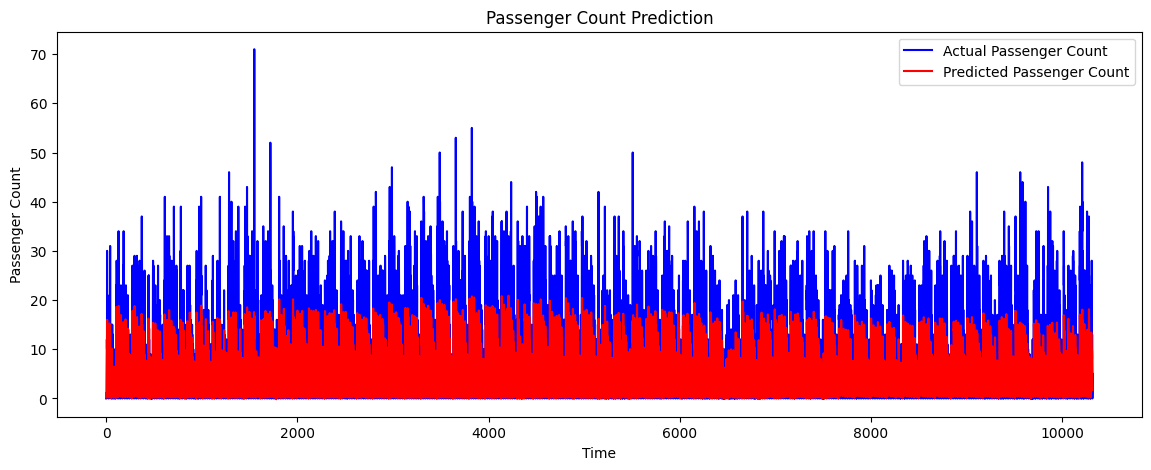

In [20]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_scaled, color='blue', label='Actual Passenger Count')
plt.plot(y_pred_scaled, color='red', label='Predicted Passenger Count')
plt.title('Passenger Count Prediction')
plt.xlabel('Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()